## Fine-tune the Vision Transformer on 5 Flower Types Classification Dataset


In this notebook, we are going to fine-tune a pre-trained [Vision Transformer](https://huggingface.co/docs/transformers/model_doc/vit) (which I added to [Transformers](https://github.com/huggingface/transformers)) on the Fashion Product Images dataset.

We will prepare the data using [datasets](https://github.com/huggingface/datasets), and train the model using the [Trainer](https://huggingface.co/transformers/main_classes/trainer.html). For other notebooks (such as training ViT with PyTorch Lightning), I refer to my repo [Transformers-Tutorials](https://github.com/NielsRogge/Transformers-Tutorials). 



In [1]:
#!pip install -q transformers datasets


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import timm
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
#from torchvision.datasets import YourCustomDataset
from torchvision.transforms import ToTensor

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/home/ali/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading the data
Here we load Fashion Products, a famous fashion image dataset, from HuggingFace's [hub](https://huggingface.co/datasets/ceyda/fashion-products-small). Note that you can view all examples of the dataset directly in your browser!

Note: if you want to load your custom image classification dataset, check out [this guide](https://huggingface.co/docs/datasets/image_load).

For demonstration purposes, we will only actually use a small portion.

In [3]:
from datasets import load_dataset

#train_ds = load_dataset('miladfa7/5-Flower-Types-Classification-Dataset')
train_ds = load_dataset('flower/Train/')
val_ds = load_dataset('flower/Test/')

Resolving data files: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4131/4131 [00:00<00:00, 50523.76it/s]
Extracting data files: 0it [00:00, ?it/s]
Generating train split: 4131 examples [00:00, 17543.42 examples/s]
Resolving data files: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:00<00:00, 778583.38it/s]
Extracting data files: 0it [00:00, ?it/s]
Generating train split: 186 examples [00:00, 13248.54 examples/s]


In [4]:
train_ds = train_ds['train'].train_test_split(test_size=0.15)
train_ds1 = val_ds['train'].train_test_split(test_size=0.00001)
train_data = train_ds['train']
test_data = train_ds['test']
validation_data = train_ds1['train']

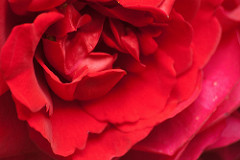

In [5]:
train_data[58]['image']


In [6]:
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np

print("Number of train samples: ", len(train_data))
print("Number of test samples: ", len(test_data))
print("Number of validation samples: ", len(validation_data))
#print("Detected Classes are: ", train_ds.class_to_idx)

Number of train samples:  3511
Number of test samples:  620
Number of validation samples:  185


Of course, we would like to know the actual class name, rather than the 

---

integer index. We can obtain that by creating a dictionary which maps between integer indices and actual class names (id2label):

In [135]:
label = list(set(train_data['label']))
id2label = {id:label for id, label in enumerate(label)}
label2id = {label:id for id,label in id2label.items()}
print(id2label, label2id)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4} {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}


## Preprocessing the data

We will now preprocess the data. The model requires 2 things: `pixel_values` and `labels`. 

We will perform data augmentaton **on-the-fly** using HuggingFace Datasets' `set_transform` method (docs can be found [here](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=set_transform#datasets.Dataset.set_transform)). This method is kind of a lazy `map`: the transform is only applied when examples are accessed. This is convenient for tokenizing or padding text, or augmenting images at training time for example, as we will do here. 

In [136]:
from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

In [137]:
#!pip install torchvision

For data augmentation, one can use any available library. Here we'll use torchvision's [transforms module](https://pytorch.org/vision/stable/transforms.html).

In [138]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]
print("Size: ", size)

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            Resize((size, size)),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize((size, size)),
            # CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

Size:  224


In [163]:
# Set the transforms
train_data.set_transform(train_transforms)
# val_ds.set_transform(val_transforms)
test_data.set_transform(val_transforms)
validation_data.set_transform(val_transforms)

It's very easy to create a corresponding PyTorch DataLoader, like so:

In [164]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([label2id[example["label"]] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_data, collate_fn=collate_fn, batch_size=4)
test_dataloader = DataLoader(test_data, collate_fn=collate_fn, batch_size=4)
validation_dataloader = DataLoader(validation_data, collate_fn=collate_fn, batch_size=4)

In [165]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [166]:
batch = next(iter(test_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [167]:
batch = next(iter(validation_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [143]:
#!pip install scipy

## Define the model

Here we define the model. We define a `ViTForImageClassification`, which places a linear layer ([nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)) on top of a pre-trained `ViTModel`. The linear layer is placed on top of the last hidden state of the [CLS] token, which serves as a good representation of an entire image. 

The model itself is pre-trained on ImageNet-21k, a dataset of 14 million labeled images. You can find all info of the model we are going to use [here](https://huggingface.co/google/vit-base-patch16-224-in21k).

We also specify the number of output neurons by setting the id2label and label2id mapping, which we be added as attributes to the configuration of the model (which can be accessed as `model.config`).

In [144]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  id2label=id2label,
                                                  label2id=label2id)

GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [145]:
#pip install accelerate -U

To instantiate a `Trainer`, we will need to define three more things. The most important is the `TrainingArguments`, which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional.

We also set the argument "remove_unused_columns" to False, because otherwise the "img" column would be removed, which is required for the data transformations.

In [146]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#writer = SummaryWriter()  # Create a SummaryWriter instance for logging

In [147]:
#if torch.cuda.device_count() > 1:
#    print("Using", torch.cuda.device_count(), "GPUs!")
#    model = nn.DataParallel(model)

#model.to(device)

In [148]:
from transformers import TrainingArguments, Trainer
import evaluate

metric_name = "accuracy"
#metric_name = evaluate.load("accuracy")

args = TrainingArguments(
    "5-Flower-Types-Classification-Ali",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5, #0.00002
    per_device_train_batch_size=32,
    per_device_eval_batch_size=4,
    num_train_epochs=50,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [149]:
#!pip install -U scikit-learn scipy matplotlib

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, set the training and evaluation batch_sizes and customize the number of epochs for training, as well as the weight decay.

We also define a `compute_metrics` function that will be used to compute metrics at evaluation. We use "accuracy" here.


In [150]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [151]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    #eval_dataset=validation_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

## Train the model


In [152]:
trainer.train()

/home/ali/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.814251,0.948387
2,No log,0.360461,0.958065
3,No log,0.239157,0.970968
4,No log,0.195466,0.966129
5,No log,0.164710,0.967742
6,No log,0.159687,0.970968
7,No log,0.151661,0.964516
8,No log,0.137308,0.972581
9,No log,0.138113,0.970968
10,0.292900,0.141531,0.967742


/home/ali/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ali/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ali/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ali/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were sca

/home/ali/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ali/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ali/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ali/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were sca

TrainOutput(global_step=2750, training_loss=0.07255217768929222, metrics={'train_runtime': 2080.6529, 'train_samples_per_second': 84.373, 'train_steps_per_second': 1.322, 'total_flos': 1.3604084554327142e+19, 'train_loss': 0.07255217768929222, 'epoch': 50.0})

In [153]:
trainer.save_model("tuned_models/flower_classifier")
# Step 2: Save the checkpoint (example)
#trainer.save_model("path/to/saved_checkpoint")

In [160]:
#Step 3: Load the checkpoint and perform inference on new test data
# Load the checkpoint
#loaded_model = ViTForImageClassification.from_pretrained("tuned_models/flower_classifier")

#Load a ViT feature extractor
#feature_extractor = ViTFeatureExtractor.from_pretrained("path/to/saved_checkpoint")

## Evaluation

Finally, let's evaluate the model on the test set:

In [180]:
outputs = trainer.predict(test_data)

/home/ali/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [181]:
print(outputs.metrics)

{'test_loss': 0.13730822503566742, 'test_accuracy': 0.9725806451612903, 'test_runtime': 7.2695, 'test_samples_per_second': 85.288, 'test_steps_per_second': 10.73}


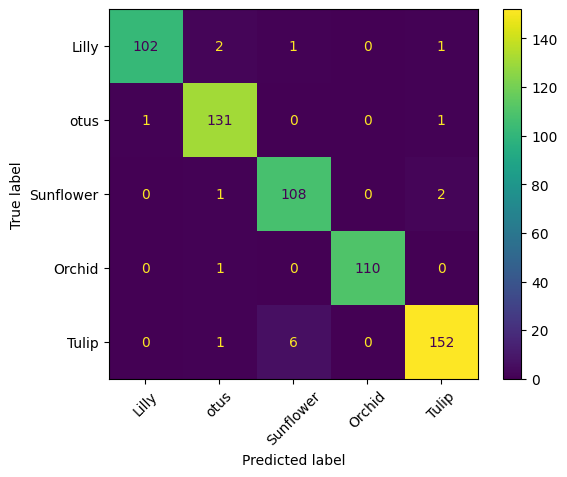

In [182]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
labels = ["Lilly", "otus", "Sunflower","Orchid", "Tulip"]
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [183]:
outputs = trainer.predict(validation_data)

/home/ali/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [184]:
print(outputs.metrics)

{'test_loss': 0.17748713493347168, 'test_accuracy': 0.9513513513513514, 'test_runtime': 2.1499, 'test_samples_per_second': 86.049, 'test_steps_per_second': 11.163}


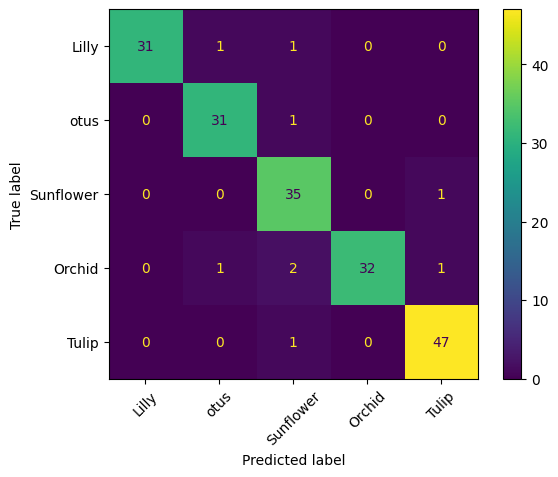

In [185]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
labels = ["Lilly", "otus", "Sunflower","Orchid", "Tulip"]
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [7]:
import torch
#from your_model_module import ViTForImageClassification
#from transformers import ViTForImageClassification

# Load the model architecture
#model = ViTForImageClassification()  # Make sure this matches the original model architecture
#model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  id2label=id2label,
                                                  label2id=label2id)

# Load the model state dictionary
#checkpoint = torch.load('/home/ali/projects/Image-Classification-Vision-Transformer/notebooks/5-Flower-Types-Classification-Ali/checkpoint-110/optimizer.pt')
#model.load_state_dict(checkpoint)

NameError: name 'id2label' is not defined

In [9]:
#For infereccing on single image 

from PIL import Image
import matplotlib.pyplot as plt

# Load and preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = val_transforms['val'](image)
    image = image.unsqueeze(0)  # Add a batch dimension
    return image


# Display the test image
def display_image(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

image_path = 'flower/Test/sunflower/23356825566_f5885875f2.jpg'  # Replace with the actual image path
preprocessed_image = preprocess_image(image_path)

NameError: name 'val_transforms' is not defined